In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM, Bidirectional, GRU, GlobalMaxPool1D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
import pydot
import IPython
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model


In [5]:
import seaborn as sns

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [7]:
train = pd.read_csv('./train.csv')
#test = pd.read_csv('./test.csv')


In [8]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_y = train[list_classes].values
train_x= train["comment_text"]


In [9]:
np.random.seed(42)

num_samples = 80000
train_samples = 48000
val_samples = int(train_samples + ((num_samples-train_samples)/2))
samples = np.random.choice(len(train_x), num_samples)
train_X = train_x[samples[0:train_samples]]
train_Y = train_y[samples[0:train_samples]]
val_X = train_x[samples[train_samples:val_samples]]
val_Y = train_y[samples[train_samples: val_samples]]
test_X = train_x[samples[val_samples:num_samples]]
test_Y = train_y[samples[val_samples:num_samples]]

In [10]:
print(train_X.head())
print(test_X.head())

121958    You are WRONG. \n\nJustin Thompson is mentione...
146867    "\n\n British Bands?  \n\nI think you've mista...
131932    I won't stop that. Sometimes Germanic equals G...
103694    Back it up. Post the line here with the refere...
119879    REDIRECT Talk:John Loveday (experimental physi...
Name: comment_text, dtype: object
41070     G'day Mackequine, and welcome to Wikipedia!\n\...
11974     Add Media Matters back\n add Opposition to the...
114031    "==Really, guys?==\nIf you hate President Bush...
18608     Effects under £2000 - dated 24th August, 1860....
150547    "\nJust a heads up those people asking you to ...
Name: comment_text, dtype: object


In [11]:
train_y_df = pd.DataFrame(train_Y, columns=list_classes)
rowsums=train_y_df.iloc[:,0:].sum(axis=1)
train_y_df['clean']=(rowsums==0)
print(train_y_df['clean'].sum())
# Print the DataFrame
print(train_y_df)


43107
       toxic  severe_toxic  obscene  threat  insult  identity_hate  clean
0          0             0        0       0       0              0   True
1          0             0        0       0       0              0   True
2          1             0        0       0       0              0  False
3          0             0        0       0       0              0   True
4          0             0        0       0       0              0   True
...      ...           ...      ...     ...     ...            ...    ...
47995      0             0        0       0       0              0   True
47996      0             0        0       0       0              0   True
47997      0             0        0       0       0              0   True
47998      0             0        0       0       0              0   True
47999      0             0        0       0       0              0   True

[48000 rows x 7 columns]


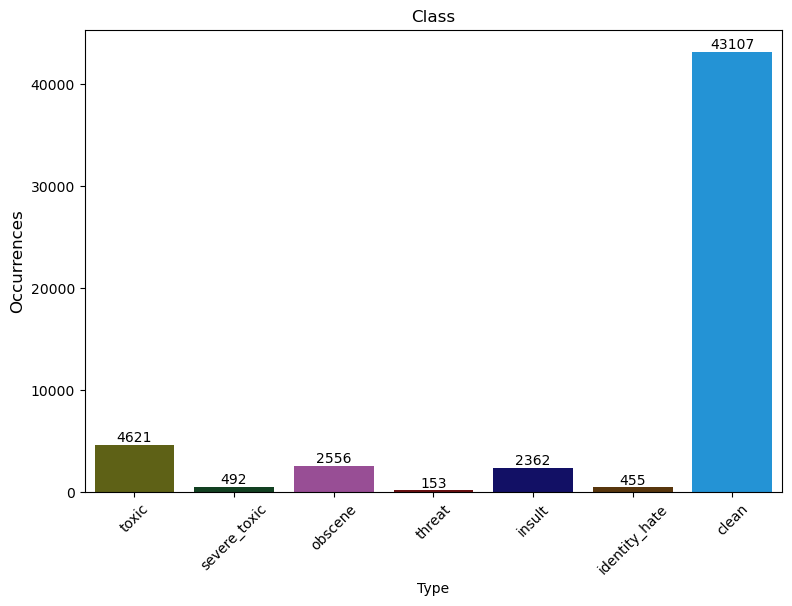

In [12]:

colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette = sns.xkcd_palette(colors_list)

x = train_y_df.iloc[:, 0:].sum()

plt.figure(figsize=(9, 6))
ax = sns.barplot(x=x.index, y=x.values, palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type')
plt.xticks(rotation=45)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, label,
            ha='center', va='bottom')

plt.show()


In [13]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
train_X = train_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
val_X = val_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
test_X = test_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)



In [14]:
print(val_X)

13234        ifd  image matt chats to jinty   jpg listed...
63172     x     n    x      n        this formula does n...
137429    please stop  if you continue to vandalize page...
21595         i want to be a fuck you    that s a song  ...
45599        i know we aren t supposed to use straw poll...
                                ...                        
36986     rfc   hi  i m informing editors who have recen...
123799       likewise a belated   thank you   for the ad...
95823     milton cooper was a criminal   why you defendi...
36602     no clarity in varna status there is no informa...
154815    jensen   is particularly notable article becau...
Name: comment_text, Length: 16000, dtype: object


In [15]:
max_words = 48000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_X)

In [16]:
train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(train_X):
    train_sequences.append(seq)

val_sequences = []
for seq in tokenizer.texts_to_sequences_generator(val_X):
    val_sequences.append(seq)


test_sequences = []

for seq in tokenizer.texts_to_sequences_generator(test_X):
    test_sequences.append(seq)
    
def find_max_list(list):
    list_len = [len(i) for i in list]
    return (max(list_len))

max_length = max(find_max_list(train_sequences),find_max_list(val_sequences), find_max_list(test_sequences))

train_padded_X = pad_sequences(train_sequences, maxlen=int(max_length/2))
val_padded_X = pad_sequences(val_sequences, maxlen=int(max_length/2))
test_padded_X = pad_sequences(test_sequences, maxlen=int(max_length/2))

#print(val_sequences[0])


In [17]:
print(test_padded_X.shape)

(16000, 700)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

In [19]:
# mlb = MultiLabelBinarizer()
# train_Y_slf = mlb.fit_transform(train_Y)
# test_Y_slf = mlb.fit_transform(test_Y)

In [20]:
# def eval_model(model, X_train, Y_train, X_test, Y_test):
#     fig = plt.figure(figsize=[25, 8])
#     ax = fig.add_subplot(1, 2, 1)
#     conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
#     pred = model.predict(X_train)
#     conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
#     ax = fig.add_subplot(1, 2, 2)
#     conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
#     pred = model.predict(X_test)
#     conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

In [21]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    # Convert multilabel-indicator to single-label format
    mlb = MultiLabelBinarizer()
    Y_train_single = mlb.fit_transform(Y_train)
    Y_test_single = mlb.transform(Y_test)
    
    # Training set evaluation
    train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train_single, train_pred)
    train_cm = confusion_matrix(Y_train_single.ravel(), train_pred.ravel())

    print("Training Set Accuracy: {:.2f}%".format(train_accuracy * 100))
    print("Training Set Confusion Matrix:")
    print(train_cm)

    # Testing set evaluation
    test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test_single, test_pred)
    test_cm = confusion_matrix(Y_test_single.ravel(), test_pred.ravel())

    print("Testing Set Accuracy: {:.2f}%".format(test_accuracy * 100))
    print("Testing Set Confusion Matrix:")
    print(test_cm)

In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_padded_X, train_Y)

RandomForestClassifier(random_state=42)

In [23]:
train_pred = rf.predict(train_padded_X)
train_accuracy = accuracy_score(train_Y, train_pred)

In [24]:
# Print the accuracy
print("Training Set Accuracy: {:.2f}%".format(train_accuracy * 100))


Training Set Accuracy: 99.96%


In [25]:
train_predictions = rf.predict(train_padded_X)
pred_binary = np.where(train_predictions > 0.5, 1, 0)

In [26]:
test_predictions2 = rf.predict(test_padded_X)
pred_binary2 = np.where(test_predictions2 > 0.5, 1, 0)

In [27]:
#print(pred_binary)
print(pred_binary2)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [28]:
train_Y_single = np.argmax(train_Y, axis=1)
pred_single = np.argmax(pred_binary, axis=1)
print(train_Y_single.shape)
print(pred_single.shape)

test_Y_single = np.argmax(test_Y, axis=1)
pred_single2 = np.argmax(pred_binary2, axis=1)
print(test_Y_single.shape)
print(pred_single2.shape)

(48000,)
(48000,)
(16000,)
(16000,)


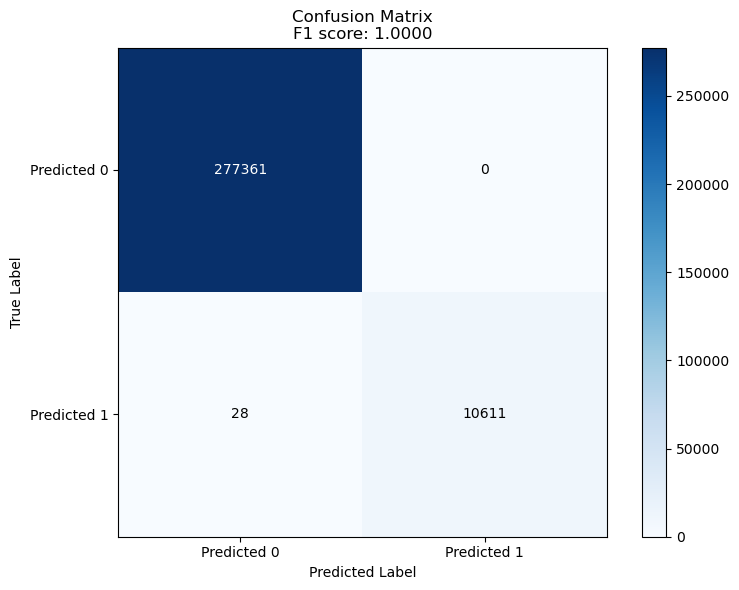

In [29]:
train_Y_single = np.argmax(train_Y, axis=1)
pred_single = np.argmax(pred_binary, axis=1)

#f1_score = f1_score(test_Y_single, pred_single, average='weighted')
f1_1 = f1_score(train_Y_single, pred_single, average='weighted')
#Get the number of classes
num_classes = len(list_classes)

#Calculate the confusion matrix
cm = np.zeros((2, 2))
for i in range(num_classes):
    true_positives = np.sum(np.logical_and(train_Y[:, i] == 1, pred_binary[:, i] == 1))
    false_positives = np.sum(np.logical_and(train_Y[:, i] == 0, pred_binary[:, i] == 1))
    true_negatives = np.sum(np.logical_and(train_Y[:, i] == 0, pred_binary[:, i] == 0))
    false_negatives = np.sum(np.logical_and(train_Y[:, i] == 1, pred_binary[:, i] == 0))

    cm[0, 0] += true_negatives
    cm[0, 1] += false_positives
    cm[1, 0] += false_negatives
    cm[1, 1] += true_positives

#Set the tick labels and locations
tick_labels = ['Predicted 0', 'Predicted 1']
tick_locations = np.arange(len(tick_labels))

#Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=tick_locations, yticks=tick_locations,
       xticklabels=tick_labels, yticklabels=tick_labels,
       ylabel='True Label',
       xlabel='Predicted Label',
       title=f'Confusion Matrix\nF1 score: {f1_1:.4f}')

#Loop over data dimensions and create text annotations with appropriate color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'  # Adjust text color based on cell value
        ax.text(j, i, format(int(cm[i, j]), 'd'), ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()

In [31]:
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(rf.estimators_[0], filled=True) 

NameError: name 'tree' is not defined

<Figure size 2000x1500 with 0 Axes>

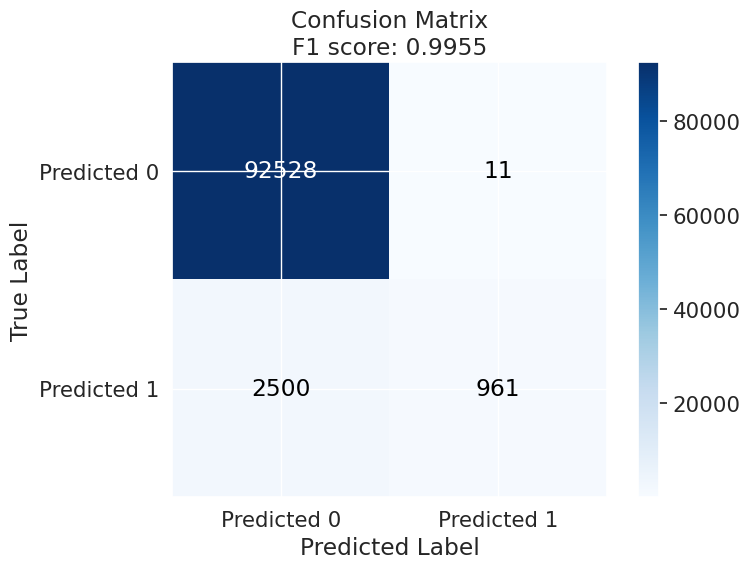

In [94]:
test_Y_single = np.argmax(test_Y, axis=1)
pred_single2 = np.argmax(pred_binary2, axis=1)

#f1_score = f1_score(test_Y_single, pred_single, average='weighted')
f1_1 = f1_score(test_Y_single, pred_single2, average='weighted')
#Get the number of classes
num_classes = len(list_classes)

#Calculate the confusion matrix
cm = np.zeros((2, 2))
for i in range(num_classes):
    true_positives = np.sum(np.logical_and(test_Y[:, i] == 1, pred_binary2[:, i] == 1))
    false_positives = np.sum(np.logical_and(test_Y[:, i] == 0, pred_binary2[:, i] == 1))
    true_negatives = np.sum(np.logical_and(test_Y[:, i] == 0, pred_binary2[:, i] == 0))
    false_negatives = np.sum(np.logical_and(test_Y[:, i] == 1, pred_binary2[:, i] == 0))

    cm[0, 0] += true_negatives
    cm[0, 1] += false_positives
    cm[1, 0] += false_negatives
    cm[1, 1] += true_positives

#Set the tick labels and locations
tick_labels = ['Predicted 0', 'Predicted 1']
tick_locations = np.arange(len(tick_labels))

#Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=tick_locations, yticks=tick_locations,
       xticklabels=tick_labels, yticklabels=tick_labels,
       ylabel='True Label',
       xlabel='Predicted Label',
       title=f'Confusion Matrix\nF1 score: {f1_1:.4f}')

#Loop over data dimensions and create text annotations with appropriate color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'  # Adjust text color based on cell value
        ax.text(j, i, format(int(cm[i, j]), 'd'), ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()

In [96]:
from sklearn import tree

In [ ]:
# Plot the Random Forest
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), dpi=300)
tree.plot_forest(rf, filled=True, feature_names=iris.feature_names, class_names=iris.target_names, ax=axes)
plt.show()

# disregard below code

In [ ]:
# inp = Input(shape=(int(max_length/2), ))
# x = Embedding(max_words, 128)(inp)
# x = LSTM(64, return_sequences=True,name='lstm_layer')(x)
# x = GlobalMaxPool1D()(x)
# x = Dropout(0.5)(x)
# x = Dense(32, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(16, activation="relu")(x)
# x = Dropout(0.5)(x)

# x = Dense(6, activation='sigmoid')(x)
# model = Model(inputs=inp, outputs=x)

# print(model.summary())
# model_2=Model(inputs=inp, outputs=x)
# model_2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])


In [ ]:
# history = model_2.fit(train_padded_X, train_Y,
#           batch_size= 128,
#           epochs=5,
#           validation_data= [val_padded_X, val_Y])

In [ ]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(1, len(loss)+1)

# plt.plot(epochs, loss, label='Training loss')
# plt.plot(epochs, val_loss, label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show();

In [ ]:
# loss = history.history['accuracy']
# val_loss = history.history['val_accuracy']

# epochs = range(1, len(loss)+1)

# plt.plot(epochs, loss, label='Accuracy')
# plt.plot(epochs, val_loss, label='Validation Accuracy')
# plt.title('Accuracy and validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show();

In [ ]:
# pred=model_2.predict(test_padded_X)

# pred_binary = (pred > 0.5).astype(int)
# # Convert predictions to one\s and zeros


In [ ]:
# print(pred_binary)